# TP1 EDA UCDP GEDEvent 25.1


En este TP se muestra una visión general del dataset UCDP GEDEvent 25.1, de eventos de violencia organizada por actores armados, con resultado letal. Se pretende preparar estos datos para su uso en el entrenamiento de un modelo clasificador que pueda predecir el nivel de muertes estimado (best) agregado sobre una celda de 1,8° de latitud por 1,8° de longitud.


In [193]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
from scipy import stats as st
from scipy.stats import describe
from scipy.stats import entropy

In [194]:
# Dataset de carreras del 2024
raw_GEDEvent = pd.read_csv('../datasets/GEDEvent_v25_1.csv')

/tmp/ipykernel_8140/2568653710.py:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_GEDEvent = pd.read_csv('../datasets/GEDEvent_v25_1.csv')


---
## EDA (Exploratory Data Analysis)
---

### Columnas y tipos de datos

In [195]:
raw_GEDEvent.columns

Index(['id', 'relid', 'year', 'active_year', 'code_status', 'type_of_violence',
       'conflict_dset_id', 'conflict_new_id', 'conflict_name', 'dyad_dset_id',
       'dyad_new_id', 'dyad_name', 'side_a_dset_id', 'side_a_new_id', 'side_a',
       'side_b_dset_id', 'side_b_new_id', 'side_b', 'number_of_sources',
       'source_article', 'source_office', 'source_date', 'source_headline',
       'source_original', 'where_prec', 'where_coordinates',
       'where_description', 'adm_1', 'adm_2', 'latitude', 'longitude',
       'geom_wkt', 'priogrid_gid', 'country', 'country_id', 'region',
       'event_clarity', 'date_prec', 'date_start', 'date_end', 'deaths_a',
       'deaths_b', 'deaths_civilians', 'deaths_unknown', 'best', 'high', 'low',
       'gwnoa', 'gwnob'],
      dtype='object')

In [196]:
# Armamos un nuevo dataset con menos columnas para el análisis
GEDEvent = raw_GEDEvent.drop(columns=['id', 'relid', 'year', 'active_year', 'code_status',
       'conflict_dset_id', 'conflict_new_id', 'conflict_name', 'dyad_dset_id',
       'dyad_new_id', 'dyad_name', 'side_a_dset_id', 'side_a_new_id', 'number_of_sources',
       'source_article', 'source_office', 'source_date', 'source_headline',
       'source_original', 'where_prec', 'where_coordinates',
       'where_description', 'adm_2',
       'side_b_dset_id', 'side_b_new_id','geom_wkt', 'priogrid_gid', 'country_id',
       'event_clarity', 'date_prec', 'deaths_a',
       'deaths_b', 'deaths_unknown', 'high', 'low',
       'gwnoa', 'gwnob'], axis=1)

In [197]:
GEDEvent.shape

(385918, 12)

In [198]:
GEDEvent.columns

Index(['type_of_violence', 'side_a', 'side_b', 'adm_1', 'latitude',
       'longitude', 'country', 'region', 'date_start', 'date_end',
       'deaths_civilians', 'best'],
      dtype='object')


### Detalles de las columnas del dataset

### Fecha de inicio y fin
* date_start
* date_end                       

### Coordenadas geográficas    
* latitude
* longitude

### Muertes del evento
* best:                                     La mejor estimación (más probable) del total 
                                            de muertes resultantes de un evento.
* deaths_civilians

### Continente, país y subdivisión     
* region:                                   Africa, Americas, Asia, Europe, Middle East
* country
* adm_1:                                    "Provincia" donde ocurrió el evento

### Tipo de violencia y actores
* type_of_violence:                         1 - conflicto estatal
                                            2 - conflicto no estatal
                                            3 - violencia unilateral
* side_a
* side_b


In [199]:
# Reordeno las columnas para poder identificarlas y analizarlas más cómodamente 
nuevo_orden = ['date_start', 'date_end',                           # Fecha de inicio y fin
               'latitude', 'longitude',                            # Coordenadas geográficas    
               'best', 'deaths_civilians',                         # Muertes del evento
               'region', 'country', 'adm_1',                       # Continente, país y subdivisión
               'type_of_violence', 'side_a', 'side_b',             # Tipo de violencia y actores
]
GEDEvent = GEDEvent[nuevo_orden]

### Vista general del dataset

In [200]:
GEDEvent.head(10)

,date_start,date_end,latitude,longitude,best,deaths_civilians,region,country,adm_1,type_of_violence,side_a,side_b
0,2017-07-31 00:00:00.000,2017-07-31 00:00:00.000,34.531094,69.162796,6,0,Asia,Afghanistan,Kabul province,1,Government of Iraq,IS
1,2021-08-26 00:00:00.000,2021-08-26 00:00:00.000,34.564444,69.217222,183,141,Asia,Afghanistan,Kabul province,1,Government of Iraq,IS
2,2021-08-28 00:00:00.000,2021-08-28 00:00:00.000,34.428844,70.455750,2,0,Asia,Afghanistan,Nangarhar province,1,Government of Iraq,IS
3,2021-08-29 00:00:00.000,2021-08-29 00:00:00.000,34.531094,69.162796,10,10,Asia,Afghanistan,Kabul province,1,Government of Iraq,IS
4,1989-01-07 00:00:00.000,1989-01-13 00:00:00.000,34.333330,70.416670,6,0,Asia,Afghanistan,Nangarhar province,1,Government of Afghanistan,Jam'iyyat-i Islami-yi Afghanistan
5,1989-01-15 00:00:00.000,1989-01-18 00:00:00.000,36.750000,68.750000,4,0,Asia,Afghanistan,Kunduz province,1,Government of Afghanistan,Jam'iyyat-i Islami-yi Afghanistan
6,1989-01-23 00:00:00.000,1989-01-24 00:00:00.000,35.315833,69.038889,600,0,Asia,Afghanistan,Baghlan province,1,Government of Afghanistan,Jam'iyyat-i Islami-yi Afghanistan
7,1989-01-30 00:00:00.000,1989-02-05 00:00:00.000,34.531094,69.162796,2,0,Asia,Afghanistan,Kabul province,1,Government of Afghanistan,Jam'iyyat-i Islami-yi Afghanistan
8,1989-01-31 00:00:00.000,1989-01-31 00:00:00.000,35.316030,69.038710,70,0,Asia,Afghanistan,Baghlan province,1,Government of Afghanistan,Jam'iyyat-i Islami-yi Afghanistan
9,1989-02-04 00:00:00.000,1989-02-04 00:00:00.000,34.500000,62.000000,20,0,Asia,Afghanistan,Hirat province,1,Government of Afghanistan,Jam'iyyat-i Islami-yi Afghanistan


In [201]:
GEDEvent.iloc[0]

date_start          2017-07-31 00:00:00.000
date_end            2017-07-31 00:00:00.000
latitude                          34.531094
longitude                         69.162796
best                                      6
deaths_civilians                          0
region                                 Asia
country                         Afghanistan
adm_1                        Kabul province
type_of_violence                          1
side_a                   Government of Iraq
side_b                                   IS
Name: 0, dtype: object

In [202]:
GEDEvent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385918 entries, 0 to 385917
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   date_start        385918 non-null  object 
 1   date_end          385918 non-null  object 
 2   latitude          385918 non-null  float64
 3   longitude         385918 non-null  float64
 4   best              385918 non-null  int64  
 5   deaths_civilians  385918 non-null  int64  
 6   region            385918 non-null  object 
 7   country           385918 non-null  object 
 8   adm_1             366371 non-null  object 
 9   type_of_violence  385918 non-null  int64  
 10  side_a            385918 non-null  object 
 11  side_b            385918 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 35.3+ MB


In [203]:
# Me fijo si hay algún valor raro en posición
GEDEvent[(GEDEvent['latitude'] < -90) | (GEDEvent['latitude'] > 90)]

,date_start,date_end,latitude,longitude,best,deaths_civilians,region,country,adm_1,type_of_violence,side_a,side_b


### Ajustamos los tipos de datos

In [204]:

         
# Numéricas temporales         
GEDEvent['date_start'] = pd.to_datetime(GEDEvent['date_start'])
GEDEvent['date_end'] = pd.to_datetime(GEDEvent['date_end'])

# Categóricas
GEDEvent['region'] = GEDEvent['region'].astype('category')
GEDEvent['country'] = GEDEvent['country'].astype('category')
GEDEvent['adm_1'] = GEDEvent['adm_1'].astype('category')
GEDEvent['type_of_violence'] = GEDEvent['type_of_violence'].astype('category')
GEDEvent['side_a'] = GEDEvent['side_a'].astype('category')
GEDEvent['side_b'] = GEDEvent['side_b'].astype('category')




In [205]:
GEDEvent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385918 entries, 0 to 385917
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date_start        385918 non-null  datetime64[ns]
 1   date_end          385918 non-null  datetime64[ns]
 2   latitude          385918 non-null  float64       
 3   longitude         385918 non-null  float64       
 4   best              385918 non-null  int64         
 5   deaths_civilians  385918 non-null  int64         
 6   region            385918 non-null  category      
 7   country           385918 non-null  category      
 8   adm_1             366371 non-null  category      
 9   type_of_violence  385918 non-null  category      
 10  side_a            385918 non-null  category      
 11  side_b            385918 non-null  category      
dtypes: category(6), datetime64[ns](2), float64(2), int64(2)
memory usage: 21.1 MB


---

---
### Variables categóricas: exploración
---

In [206]:
GEDEvent[GEDEvent['best'] == '0']

,date_start,date_end,latitude,longitude,best,deaths_civilians,region,country,adm_1,type_of_violence,side_a,side_b


In [207]:
GEDEvent.describe(include='category')

,region,country,adm_1,type_of_violence,side_a,side_b
count,385918,385918,366371,385918,385918,385918
unique,5,124,1682,3,966,959
top,Middle East,Syria,Rif Dimashq governorate,1,Government of Syria,Syrian insurgents
freq,122215,87861,17487,271331,75181,66186


#### Corredor y equipo

In [230]:
# Top 10 Actor A
GEDEvent['side_a'].unique()

['Government of Iraq', 'Government of Afghanistan', 'Government of India', 'Government of Tajikistan', 'Government of Pakistan', ..., 'Al-Maraziq', 'Forces of the Presidential Leadership Council', 'Abu al-Abbas Brigades', 'Giants Brigade, STC', 'Government of United Kingdom, Government of U...]
Length: 966
Categories (966, object): ['16th Division, Islamic Front, Jabhat Fateh al..., '1920 Revolution Brigades', '23rd Division, Ahrar al-Sham, Jaysh al Nasr, ..., '23rd Division, Jaysh al Nasr, Jaysh al-Nukhba..., ..., 'al-Qaida', 'al-Tawhid Brigade', 'anti-Balaka', 'anti-Balaka, FPRC-AK']

In [245]:
# Frecuencias absoluta y relativa
Ev= GEDEvent['side_a'].count()
print()
print("EDA variables categóricas.")
print()
print("side_a")
print()
v_counts = GEDEvent['side_a'].value_counts().head(10)
porcentajes = (v_counts / Ev) * 100

for label, count, pct in zip(v_counts.index, v_counts.values, porcentajes):
    print(f"{label}: {count} ({pct:.2f}%)")
print()

v_counts = GEDEvent['side_a'].value_counts().tail(1)
porcentajes = (v_counts / Ev) * 100

for label, count, pct in zip(v_counts.index, v_counts.values, porcentajes):
    print(f"{label}: {count} ({pct:.2f}%)")
print("-" * 60)
print()
print("side_b")
print()


v_counts = GEDEvent['side_b'].value_counts().head(10)
porcentajes = (v_counts / Ev) * 100

for label, count, pct in zip(v_counts.index, v_counts.values, porcentajes):
    print(f"{label}: {count} ({pct:.2f}%)")
print()

v_counts = GEDEvent['side_b'].value_counts().tail(1)
porcentajes = (v_counts / Ev) * 100

for label, count, pct in zip(v_counts.index, v_counts.values, porcentajes):
    print(f"{label}: {count} ({pct:.2f}%)")
print("-" * 60)
print()
print("region")
print()


v_counts = GEDEvent['region'].value_counts().head(10)
porcentajes = (v_counts / Ev) * 100

for label, count, pct in zip(v_counts.index, v_counts.values, porcentajes):
    print(f"{label}: {count} ({pct:.2f}%)")
print("-" * 60)
print()
print("country")
print()


v_counts = GEDEvent['country'].value_counts().head(10)
porcentajes = (v_counts / Ev) * 100

for label, count, pct in zip(v_counts.index, v_counts.values, porcentajes):
    print(f"{label}: {count} ({pct:.2f}%)")
print()

v_counts = GEDEvent['country'].value_counts().tail(1)
porcentajes = (v_counts / Ev) * 100

for label, count, pct in zip(v_counts.index, v_counts.values, porcentajes):
    print(f"{label}: {count} ({pct:.2f}%)")
print("-" * 60)
print()
print("adm_1")
print()


v_counts = GEDEvent['adm_1'].value_counts().head(10)
porcentajes = (v_counts / Ev) * 100

for label, count, pct in zip(v_counts.index, v_counts.values, porcentajes):
    print(f"{label}: {count} ({pct:.2f}%)")
print()

v_counts = GEDEvent['adm_1'].value_counts().tail(1)
porcentajes = (v_counts / Ev) * 100

for label, count, pct in zip(v_counts.index, v_counts.values, porcentajes):
    print(f"{label}: {count} ({pct:.2f}%)")
print("-" * 60)
print()
print("type_of_violence")
print()


v_counts = GEDEvent['type_of_violence'].value_counts().head(10)
porcentajes = (v_counts / Ev) * 100

for label, count, pct in zip(v_counts.index, v_counts.values, porcentajes):
    print(f"{label}: {count} ({pct:.2f}%)")
print()
print('1:conflicto estatal - 2:conflicto no estatal - 3:violencia unilateral')
print("-" * 60)



EDA variables categóricas.

side_a

Government of Syria: 75181 (19.48%)
Government of Afghanistan: 40223 (10.42%)
Government of Russia (Soviet Union): 32460 (8.41%)
Government of India: 13011 (3.37%)
IS: 12257 (3.18%)
Government of Israel: 9524 (2.47%)
Jalisco Cartel New Generation: 9146 (2.37%)
Government of Myanmar (Burma): 8220 (2.13%)
Government of Turkey: 8014 (2.08%)
Government of Bosnia-Herzegovina: 7908 (2.05%)

16th Division, Islamic Front, Jabhat Fateh al-Sham: 1 (0.00%)
------------------------------------------------------------

side_b

Syrian insurgents: 66186 (17.15%)
Civilians: 59605 (15.44%)
Taleban: 35935 (9.31%)
Government of Ukraine: 28499 (7.38%)
IS: 21871 (5.67%)
Sinaloa Cartel: 9816 (2.54%)
PKK: 7656 (1.98%)
Kashmir insurgents: 7237 (1.88%)
Hamas: 5863 (1.52%)
Serbian Republic of Bosnia-Herzegovina: 5702 (1.48%)

Wayai subclan of Takima: 1 (0.00%)
------------------------------------------------------------

region

Middle East: 122215 (31.67%)
Asia: 97879 (25.3

In [ ]:
# Get value counts
v_counts = GEDEvent['side_a'].value_counts().head(10)

# Calculate percentages
porcentajes = (v_counts / Ev) * 100

# Combine and print
for label, count, pct in zip(counts.index, counts.values, percentages):
    print(f"{label}: {count} ({pct:.2f}%)")


Government of Syria: 75181 (19.48%)
Government of Afghanistan: 40223 (10.42%)
Government of Russia (Soviet Union): 32460 (8.41%)
Government of India: 13011 (3.37%)
IS: 12257 (3.18%)
Government of Israel: 9524 (2.47%)
Jalisco Cartel New Generation: 9146 (2.37%)
Government of Myanmar (Burma): 8220 (2.13%)
Government of Turkey: 8014 (2.08%)
Government of Bosnia-Herzegovina: 7908 (2.05%)


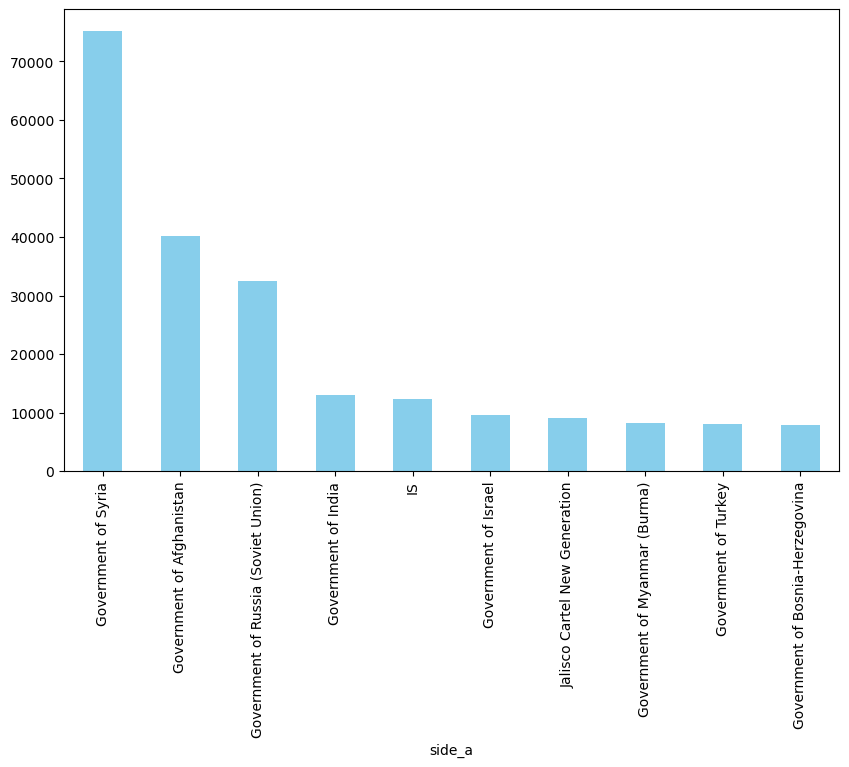

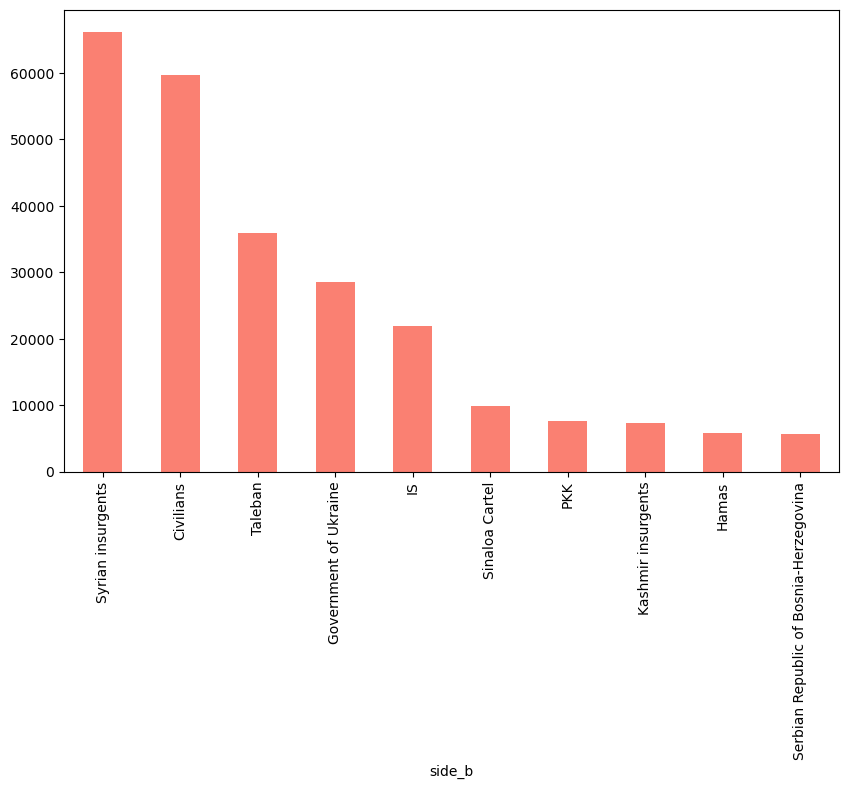

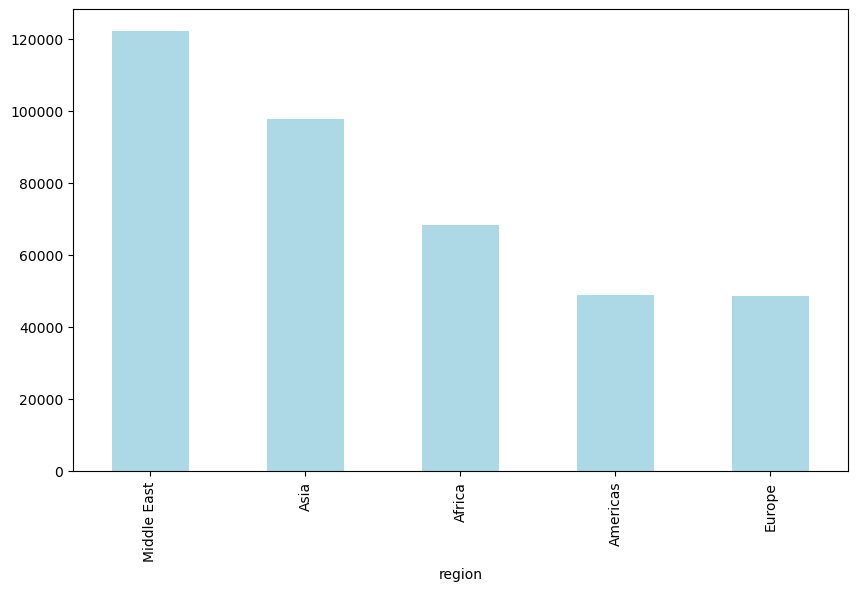

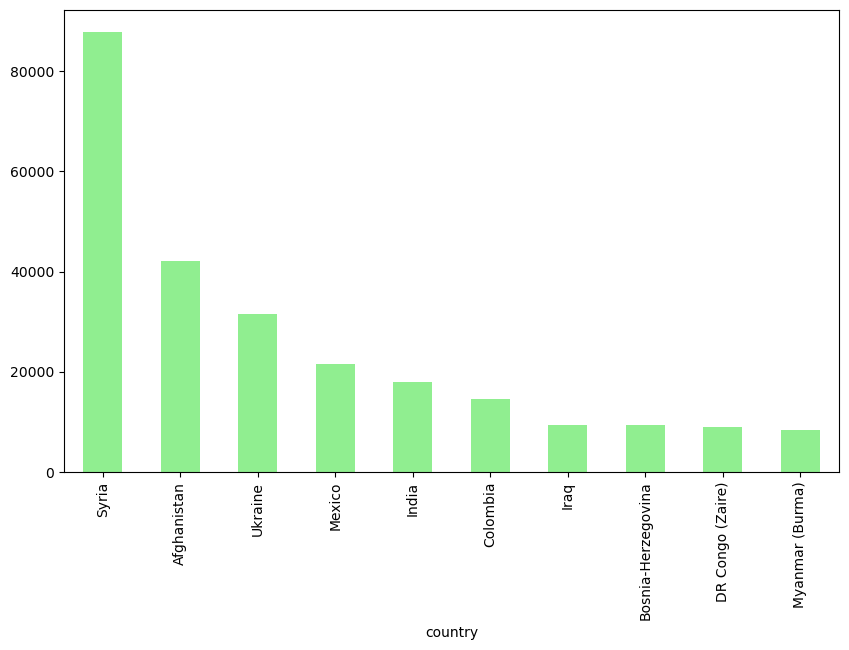

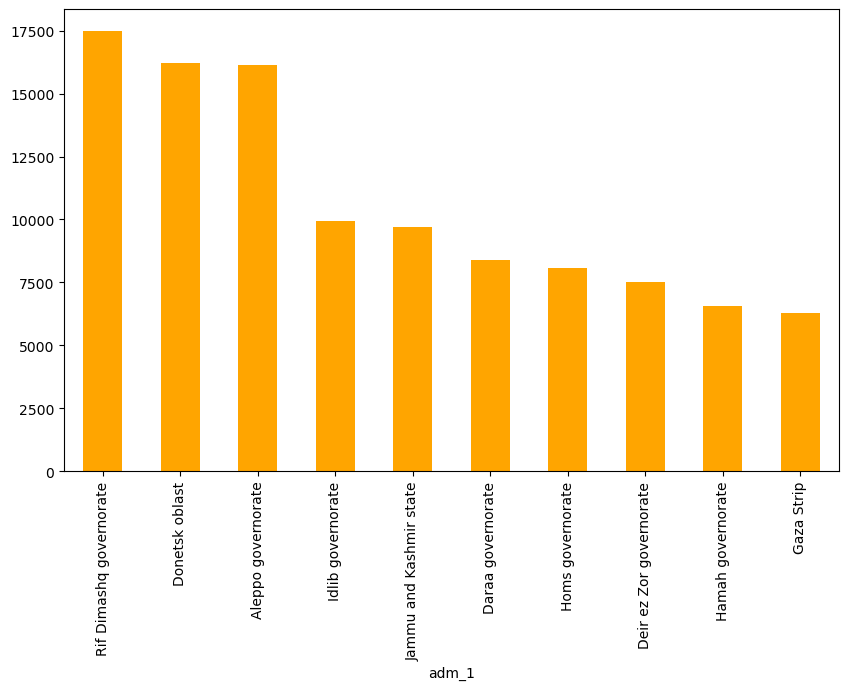

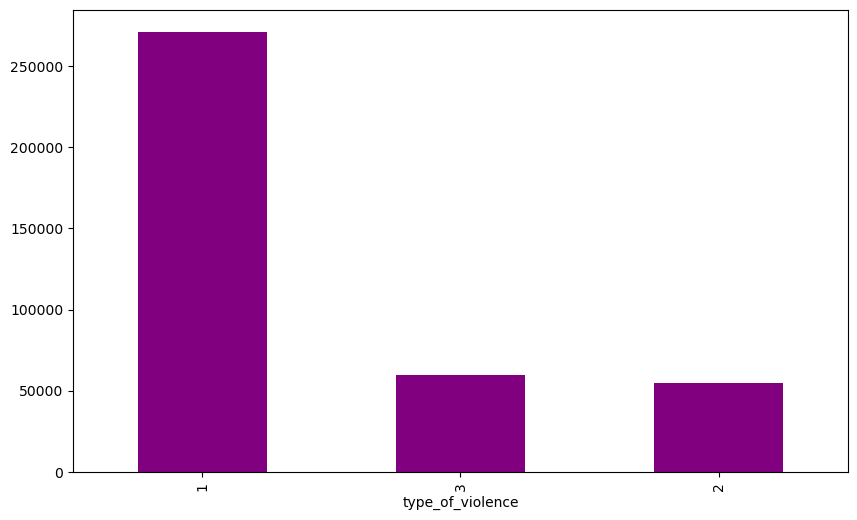

1:conflicto estatal - 2:conflicto no estatal - 3:violencia unilateral


In [210]:
top_10a = GEDEvent['side_a'].value_counts().head(10)
top_10a.plot(kind='bar', figsize=(10, 6), color='skyblue')

plt.show()

top_10b = GEDEvent['side_b'].value_counts().head(10)
top_10b.plot(kind='bar', figsize=(10, 6), color='salmon')

plt.show()

top_10a = GEDEvent['region'].value_counts().head(10)
top_10a.plot(kind='bar', figsize=(10, 6), color='lightblue')

plt.show()

top_10b = GEDEvent['country'].value_counts().head(10)
top_10b.plot(kind='bar', figsize=(10, 6), color='lightgreen')

plt.show()

top_10a = GEDEvent['adm_1'].value_counts().head(10)
top_10a.plot(kind='bar', figsize=(10, 6), color='orange')

plt.show()

top_10b = GEDEvent['type_of_violence'].value_counts().head(10)
top_10b.plot(kind='bar', figsize=(10, 6), color='purple')

plt.show()
print('1:conflicto estatal - 2:conflicto no estatal - 3:violencia unilateral')

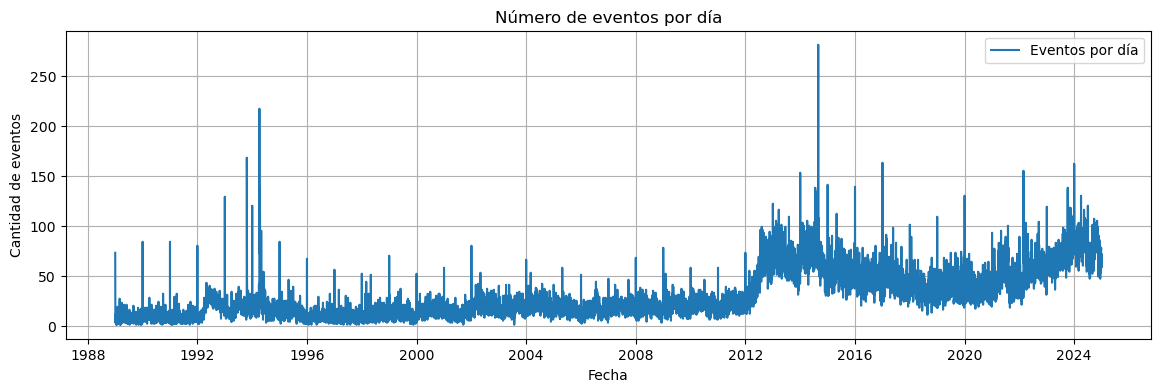

In [211]:

# Agrupar eventos por día y contar
eventos_por_dia = GEDEvent['date_start'].dt.date.value_counts().sort_index()

# Crear un DataFrame con las fechas y los conteos
df_eventos = pd.DataFrame({
    "fecha": eventos_por_dia.index,
    "cantidad_eventos": eventos_por_dia.values
})

# Graficar 
plt.figure(figsize=(14, 4))
sns.lineplot(data=df_eventos, x="fecha", y="cantidad_eventos", label="Eventos por día")

# Títulos y etiquetas
plt.title("Número de eventos por día")
plt.xlabel("Fecha")
#plt.yscale('log')
plt.ylabel("Cantidad de eventos")
plt.grid(True)
plt.show()



In [212]:
# Análisis descriptivo de la variable 'best' por región
print("Análisis descriptivo de la variable 'best' por región")
regiones = GEDEvent['region'].unique()
print("-" * 60)

for region in regiones:
    print(f"\nRegión: {region}")
    print("-" * (len(region) + 8))


    region_best = GEDEvent[GEDEvent['region'] == region]['best']
    print(f"  Suma Total: {region_best.count()}")
    print(f"  Media: {region_best.mean():.2f}")
    print(f"  Mediana: {region_best.median():.2f}")
    print(f"  Moda: {region_best.mode().tolist()}")
    print(f"  Desviación Estándar: {region_best.std():.2f}")
    print(f"  Mínimo: {region_best.min()}")
    print(f"  Cuartil 1: {region_best.quantile(0.25):.2f}")
    print(f"  Cuartil 3: {region_best.quantile(0.75):.2f}")
    print(f"  Máximo: {region_best.max()}")
    print(f"  Rango Intercuartil: {(region_best.quantile(0.75)-region_best.quantile(0.25)):.2f}")
    print(f"  Asimetría: {region_best.skew():.2f}")
    print(f"  Curtosis: {region_best.kurtosis():.2f}")
    print("-" * (len(region) + 8))



Análisis descriptivo de la variable 'best' por región
------------------------------------------------------------

Región: Asia
------------
  Suma Total: 97879
  Media: 6.05
  Mediana: 2.00
  Moda: [1]
  Desviación Estándar: 32.28
  Mínimo: 0
  Cuartil 1: 1.00
  Cuartil 3: 5.00
  Máximo: 2821
  Rango Intercuartil: 4.00
  Asimetría: 45.05
  Curtosis: 2736.50
------------

Región: Europe
--------------
  Suma Total: 48586
  Media: 7.68
  Mediana: 2.00
  Moda: [1]
  Desviación Estándar: 121.29
  Mínimo: 0
  Cuartil 1: 1.00
  Cuartil 3: 3.00
  Máximo: 15996
  Rango Intercuartil: 2.00
  Asimetría: 76.93
  Curtosis: 7965.33
--------------

Región: Africa
--------------
  Suma Total: 68354
  Media: 29.79
  Mediana: 2.00
  Moda: [1]
  Desviación Estándar: 808.10
  Mínimo: 0
  Cuartil 1: 1.00
  Cuartil 3: 7.00
  Máximo: 121848
  Rango Intercuartil: 6.00
  Asimetría: 104.19
  Curtosis: 13826.62
--------------

Región: Americas
----------------
  Suma Total: 48884
  Media: 4.80
  Mediana: 1.00


/tmp/ipykernel_8140/408585979.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  muertes_mensuales_por_region = GEDEvent.groupby('region').resample('M', on='date_start')['best'].sum().reset_index()
/tmp/ipykernel_8140/408585979.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  muertes_mensuales_por_region = GEDEvent.groupby('region').resample('M', on='date_start')['best'].sum().reset_index()
/tmp/ipykernel_8140/408585979.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  muertes_mensuales_por_region['smoothed_best'] = muertes_mensuales_por_region.grou

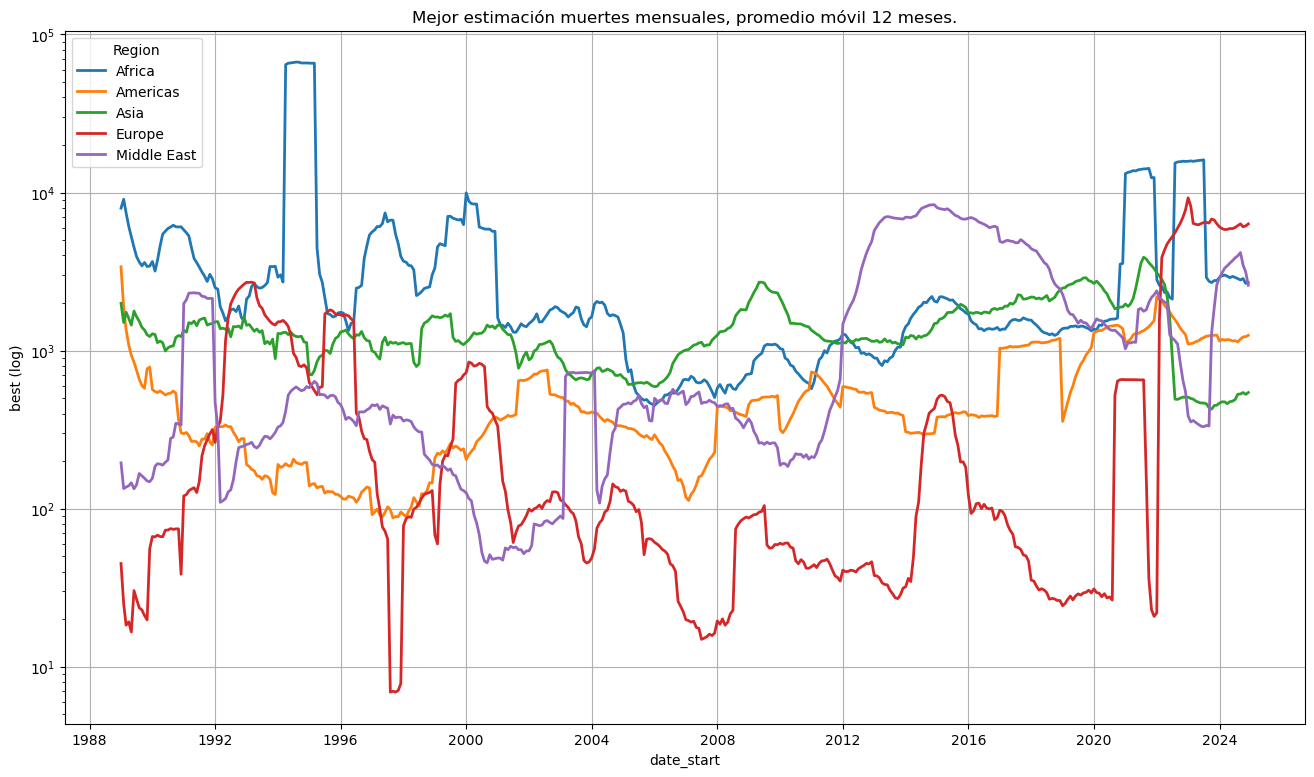

In [213]:
# Calcular muertes mensuales por región
# Agrupar por región y resamplear por mes, sumando las muertes
muertes_mensuales_por_region = GEDEvent.groupby('region').resample('M', on='date_start')['best'].sum().reset_index()
muertes_mensuales_por_region['date_start'] = muertes_mensuales_por_region['date_start'].dt.to_period('M').dt.to_timestamp()

# Promedio móvil 12 meses
muertes_mensuales_por_region['smoothed_best'] = muertes_mensuales_por_region.groupby('region')['best'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())

plt.figure(figsize=(16, 9)) 
sns.lineplot(data=muertes_mensuales_por_region, x='date_start', y='smoothed_best', hue='region', linewidth=2)


plt.title('Mejor estimación muertes mensuales, promedio móvil 12 meses.')
plt.ylabel('best (log)')
plt.yscale('log')
plt.legend(title='Region')
plt.grid(True)
plt.show()